
1. You are provided the titanic dataset. Load the dataset and perform splitting into training and test sets with 70:30 ratio randomly using test train split.
2. Use the Logistic regression created from scratch (from the prev question) in this question as well.
3. Data cleaning plays a major role in this question. Report all the methods used by you in the ipynb.

--> 

i. Check for missing values

ii. Drop Columns & Handle missing values

iii. Create dummies for categorical features

you are free to perform other data cleaning to improve your results.



4. Report accuracy score, Confusion matrix, heat map, classifiaction report and any other metrics you feel useful.

dataset link : 
https://iiitaphyd-my.sharepoint.com/:f:/g/personal/apurva_jadhav_students_iiit_ac_in/Eictt5_qmoxNqezgQQiMWeIBph4sxlfA6jWAJNPnV2SF9Q?e=mQmYN0 

(titanic.csv)


In [ ]:
!pip install mpi4py

     |████████████████████████████████| 1.4MB 6.3MB/s 
  Created wheel for mpi4py: filename=mpi4py-3.0.3-cp37-cp37m-linux_x86_64.whl size=2065177 sha256=e0aca3805c0f7c0d367f48b929c251f77f575dd4167eb5676d08cb24f23c7266
  Stored in directory: /root/.cache/pip/wheels/18/e0/86/2b713dd512199096012ceca61429e12b960888de59818871d6
Successfully built mpi4py


In [ ]:
from mpi4py import MPI

comm = MPI.COMM_WORLD
rank = comm.Get_rank()

if rank == 0:
    data = {'a': 7, 'b': 3.14}
    comm.send(data, dest=1, tag=11)
elif rank == 1:
    data = comm.recv(source=0, tag=11)

Exception: ignored

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/titanic.csv')

#begin preprocessing
cols = ['Name', 'Ticket', 'Cabin']
df = df.drop(cols, axis=1)

df['Sex'] = df['Sex'].map({'male':0, 'female':1})
df['Embarked'] = df['Embarked'].map({'C':0, 'Q':1, 'S':2})
df['Embarked'] = df['Embarked'].fillna(2)
df['Age'] = df['Age'].interpolate()
print(df.columns)
cols=['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']
X=df[cols]
y=df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Fare', 'Embarked'],
      dtype='object')


Normal gradient descent 0.7350746268656716
[[160  12]
 [ 59  37]]


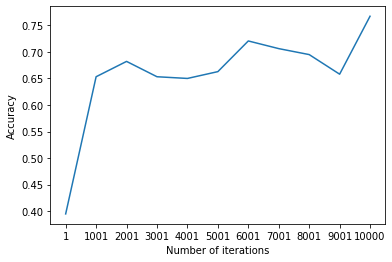

In [ ]:
class LogisticRegression_custom:
    
    def __init__(self,learning_rate=0.05,num_iterations=10000):
        self.learning_rate=learning_rate
        self.weights=None
        self.bias=None
        self.num_iterations=num_iterations
        self.accs = []
    def fit(self,X,y):
        num_samples,num_features=X.shape
        self.weights=np.ones(num_features)
        self.bias=0
        
        #gradient descent
        convergence=False
        #while(convergence is not True):
        for i in range(self.num_iterations):
        #Wx+B
            linear_model=np.dot(X,self.weights)+self.bias
            y_pred=self.sigmoid(linear_model)
            
            dw=(1/num_samples)*np.dot(X.T,(y_pred-y))
            #db=(1/num_samples)*np.sum(y_pred-y)
            old_wts=self.weights
            old_bias=self.bias
            self.weights=self.weights-self.learning_rate*dw
            #self.bias=self.bias-self.learning_rate*db            
            diff_weights=np.sum(old_wts-self.weights)
            
            y_pred[y_pred>0.5] = 1
            y_pred[y_pred<=0.5] = 0
            self.accs.append(accuracy_score(y, y_pred))
            #print(diff_weights)
            #if(diff_weights<abs(0.000001)):
            #    convergence=True
            
    def predict(self,X):
        linear_model=np.dot(X,self.weights)+self.bias
        y_pred=self.sigmoid(linear_model)
        predictions=[]
        for i in y_pred:
            if(i>0.5):
                predictions.append(1)
            else:
                predictions.append(0)
        return predictions

    def sigmoid(self,x):
        return(1/(1+np.exp(-x)))
    
    def plot_accs(self, step_size=500):
      x_data = []
      y_data = []
      for i in range(1,self.num_iterations+1,step_size):
        x_data.append(i)
        y_data.append(self.accs[i-1])
      x_data.append(self.num_iterations)
      y_data.append(self.accs[-1])
      plt.plot(x_data, y_data)
      plt.xticks(x_data)
      plt.xlabel('Number of iterations')
      plt.ylabel('Accuracy')
      plt.show()
    
if __name__ == "__main__":
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import confusion_matrix
    xcla=LogisticRegression_custom()
    xcla.fit(X_train,y_train)
    res=xcla.predict(X_test)
    print("Normal gradient descent",accuracy_score(res,y_test))
    print(confusion_matrix(y_test, res))
    xcla.plot_accs(1000)

Sign SGD 0.7313432835820896
[[160  12]
 [ 60  36]]


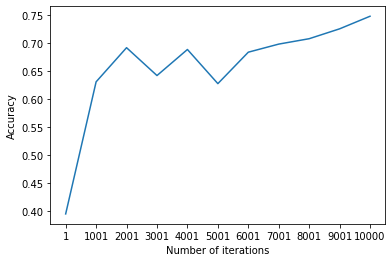

In [ ]:
#SIGNSGD
class LogisticRegression_custom:
    
    def __init__(self,learning_rate=0.05,num_iterations=10000):
        self.learning_rate=learning_rate
        self.weights=None
        self.bias=None
        self.num_iterations=num_iterations
        self.accs = []
        
    def batchgradient(self,X,y):
        num_samples,num_features=X.shape
        linear_model=np.dot(X,self.weights)
        y_pred=self.sigmoid(linear_model)
        dw=(1/num_samples)*np.dot(X.T,(y_pred-y))
        #print(dw)
        return dw
    
    def fit(self,X,y):
        num_samples,num_features=X.shape
        self.weights=np.ones(num_features)
        self.bias=0
        
        #gradient descent
        convergence=False
        X, y = shuffle(X, y)
        batches=int(math.floor((len(X)/128)))
        #while(convergence is not True):
        for i in range(self.num_iterations):
        #Wx+B
            linear_model=np.dot(X,self.weights)
            y_pred=self.sigmoid(linear_model)
            gradient=0
            vote=[0,0,0,0,0,0,0]
            for b in range(batches):
                if (b!=batches-1):
                    gradient+=self.batchgradient(X[b*128:((b+1)*128)],y[b*128:((b+1)*128)])
                else:
                    gradient+=self.batchgradient(X[b*128:len(X)],y[b*128:len(X)])
                #print(gradient)
                for i in range(len(vote)):
                    if(gradient[i]<0):
                        vote[i]+=-1
                    else:
                        vote[i]=+1
            
            dw=gradient/batches
            for i in range(len(vote)):
                if(vote[i]<0):
                    if(dw[i]>=0):
                        dw[i]=(dw[i]*-1)
                else:
                    if(dw[i]<=0):
                        dw[i]=dw[i]*-1
                
                    
            old_wts=self.weights
            #old_bias=self.bias
            
            self.weights=self.weights-self.learning_rate*dw
            #self.bias=self.bias-self.learning_rate*db            
            
            diff_weights=np.sum(old_wts-self.weights)

            y_pred[y_pred>0.5] = 1
            y_pred[y_pred<=0.5] = 0
            self.accs.append(accuracy_score(y, y_pred))
            
            #print(diff_weights)
            #if(diff_weights<abs(0.000001)):
            #    convergence=True
            
    def predict(self,X):
        linear_model=np.dot(X,self.weights)+self.bias
        y_pred=self.sigmoid(linear_model)
        predictions=[]
        for i in y_pred:
            if(i>0.5):
                predictions.append(1)
            else:
                predictions.append(0)
        return predictions

    def sigmoid(self,x):
        return(1/(1+np.exp(-x)))

    def plot_accs(self, step_size=500):
      x_data = []
      y_data = []
      for i in range(1,self.num_iterations+1,step_size):
        x_data.append(i)
        y_data.append(self.accs[i-1])
      x_data.append(self.num_iterations)
      y_data.append(self.accs[-1])
      plt.plot(x_data, y_data)
      plt.xticks(x_data)
      plt.xlabel('Number of iterations')
      plt.ylabel('Accuracy')
      plt.show()
    
if __name__ == "__main__":
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import confusion_matrix
    from sklearn.utils import shuffle
    import math
    xcla=LogisticRegression_custom()
    xcla.fit(X_train,y_train)
    res=xcla.predict(X_test)
    print("Sign SGD",accuracy_score(res,y_test))
    print(confusion_matrix(y_test, res))
    xcla.plot_accs(1000)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
